### 0. Import libraries and load data

In [109]:
import re
import json
import random
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

INPUT_FILE_PATH = "./data/flyers_text.json"
OUTPUT_FILE_PATH = "./data/flyers_wo_outliers.json"

In [110]:
# load results
with open(INPUT_FILE_PATH) as file:
    pdf_data = json.load(file)


### 1. Count text properties

In [111]:
def get_properties(header, section):
    """
    This function extracts: the number of paragraphs, words from header and section and
    average word length in header and section. After being computed, these values are returned.
    """

    # get number of paragraphs
    paragraphs_per_section = len(section.split("\n"))
    paragraphs_per_header = len(header.split("\n"))

    # split text into tokens and count them and compute average word length
    section_words = [
        word.group()
        for word in re.finditer(r"(^|\b)\w*(?=($|[^\w]))", section)
        if len(word.group()) != 0
    ]

    words_per_section = len(section_words)

    if words_per_section == 0:
        avg_word_len_section = 0
    else:
        avg_word_len_section = np.array([len(word) for word in section_words]).mean()
    header_words = [
        word.group()
        for word in re.finditer(r"(^|\b)\w*(?=($|[^\w]))", header)
        if len(word.group()) != 0
    ]

    words_per_header = len(header_words)

    if words_per_header == 0:
        avg_word_len_header = 0
    else:
        avg_word_len_header = np.array([len(word) for word in header_words]).mean()
    return (
        paragraphs_per_section,
        paragraphs_per_header,
        words_per_section,
        words_per_header,
        avg_word_len_section,
        avg_word_len_header,
    )


In [112]:
# count number of lines per header
paragraphs_per_header = []

# count number of words per header
words_per_header = []

# count number of sections per PDF
section_counter_per_pdf = []

# count number of lines per section
paragraphs_per_section = []

# count number of words per section
words_per_section = []

# store average word length per section
avg_word_len_section = []

# store average word length per header
avg_word_len_header = []

# iterate over PDFs and count various metrics
for file_name, data in dict(pdf_data).items():
    section_counter_per_pdf.append(len(data))

    # get properties for each header and section
    for header, section in data.items():
        (
            paragraphs_per_section_,
            paragraphs_per_header_,
            words_per_section_,
            words_per_header_,
            avg_word_len_section_,
            avg_word_len_header_,
        ) = get_properties(header, section)

        paragraphs_per_section.append(paragraphs_per_section_)
        paragraphs_per_header.append(paragraphs_per_header_)
        words_per_section.append(words_per_section_)
        words_per_header.append(words_per_header_)
        avg_word_len_section.append(avg_word_len_section_)
        avg_word_len_header.append(avg_word_len_header_)
number_of_sections = np.array(section_counter_per_pdf).sum()
print(f"There are {number_of_sections} sections.")


There are 13967 sections.


### 2. Define utility functions

In [113]:
def compute_statistics(property, low_percentile=0.1, high_percentile=99.9):
    """
    This function computes various statistics for the given metric, prints them
    and returns the upper bound for detecting outliers.
    """

    # compute max, min, mean, percentiles and standard deviation
    metric_max = property.max()
    metric_min = property.min()
    mean = round(property.mean(), 4)

    low_percentile_value = round(np.percentile(property, low_percentile), 4)
    high_percentile_value = round(np.percentile(property, high_percentile), 4)
    std = property.std()

    # print statistics
    print(
        f"Min: {metric_min}\nMax: {metric_max}\nMean: {mean}\
          \n{low_percentile} percentile: {low_percentile_value}\n{high_percentile} percentile: {high_percentile_value}\n"
    )

    # compute upper bound
    upper_bound = int(mean + 3 * std)

    return upper_bound, low_percentile_value, high_percentile_value


In [114]:
def separate_outliers(property, upper_bound, value):
    """
    It separates the input statistic into outliers and normal values.
    """

    large_outlier_values = [val for val in property if val >= upper_bound]
    small_outlier_values = [val for val in property if val == value]
    normal_values = [val for val in property if val < upper_bound]

    return large_outlier_values, small_outlier_values, normal_values


In [115]:
def plot(all_values, normal_values, title):
    """
    This function plots the original values and the normal ones
    (without outliers) in 2 different plots.
    """

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)

    sns.boxplot(all_values, color=sns.color_palette("mako")[1], ax=ax[0])
    ax[0].set_title("Box plot with all values")
    sns.violinplot(normal_values, color=sns.color_palette("mako")[4], ax=ax[1])
    ax[1].set_title("Violin plot with normal values")
    plt.suptitle(title)

    plt.show()


### 3. Compute statistics and detect outliers

##### 3.1. Number of sections per PDF

Min: 1
Max: 62
Mean: 10.5811          
0.1 percentile: 1.0
99.9 percentile: 52.681

There are 26 PDFs that have more than 27 sections.
There are 30 PDFs that have only one section.


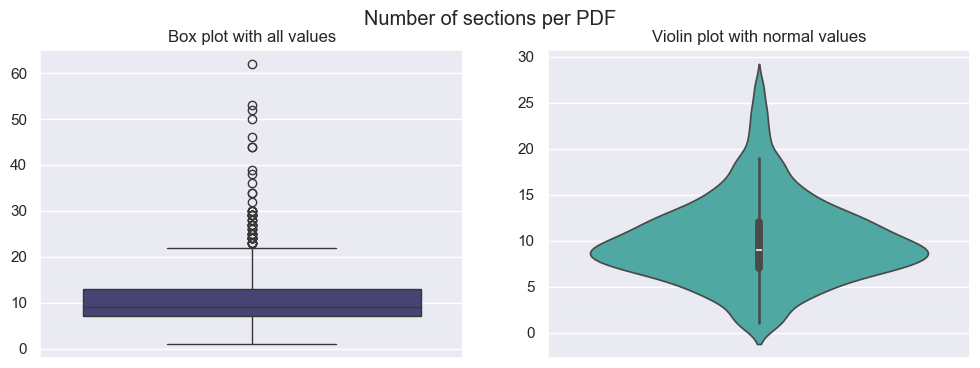

In [116]:
upper_bound_sections_no, _, _ = compute_statistics(np.array(section_counter_per_pdf))
outlier_sections, number_of_mono_sections, normal_sections = separate_outliers(
    section_counter_per_pdf, upper_bound_sections_no, 1
)
print(f"There are {len(outlier_sections)} PDFs that have more than {upper_bound_sections_no - 1} sections.")
print(f"There are {len(number_of_mono_sections)} PDFs that have only one section.")

plot(section_counter_per_pdf, normal_sections, "Number of sections per PDF")


##### 3.2. Number of paragraphs per header

In [117]:
included_values = [1]

outlier_values = np.array([])
number_of_outliers = 0

for value in paragraphs_per_header:
    if value not in included_values:
        number_of_outliers += 1
        outlier_values = np.append(outlier_values, value)
print(f"Number of outlier headers based on number of paragraphs: {number_of_outliers}.\n"
    f"These headers have {sorted(outlier_values)} paragraphs."
)


Number of outlier headers based on number of paragraphs: 4.
These headers have [2.0, 4.0, 7.0, 8.0] paragraphs.


##### 3.3. Number of paragraphs per section

Do not remove sections based on the number of paragraphs because bullet points are counted as separate paragraphs.

Min: 1
Max: 99
Mean: 1.9508          
0.1 percentile: 1.0
99.9 percentile: 24.0

There are 309 sections having more than 9 paragraphs.


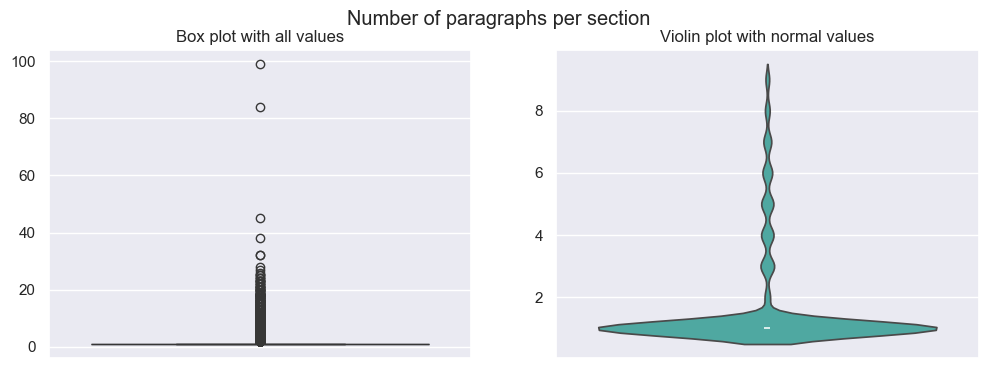

In [118]:
upper_bound_section_par, _, _ = compute_statistics(np.array(paragraphs_per_section))
outlier_sections, _, normal_sections = separate_outliers(
    paragraphs_per_section, upper_bound_section_par, 0
)
print(f"There are {len(outlier_sections)} sections having more than {upper_bound_section_par - 1} paragraphs.")

plot(paragraphs_per_section, normal_sections, "Number of paragraphs per section")


##### 3.4. Number of words per header

Min: 0
Max: 185
Mean: 3.2414          
0.1 percentile: 1.0
99.9 percentile: 23.034

There are 14 headers longer than 22.034 words.
There are 8 empty headers.


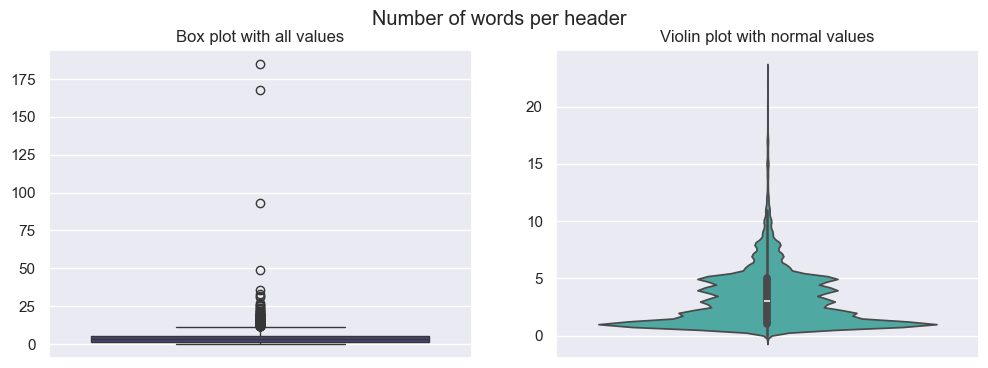

In [119]:
_, _, high_percentile_header_words = compute_statistics(np.array(words_per_header), high_percentile=99.9)
outlier_headers, number_of_empty_headers, normal_headers = separate_outliers(
    words_per_header, high_percentile_header_words, 0
)
print(f"There are {len(outlier_headers)} headers longer than {high_percentile_header_words - 1} words.")
print(f"There are {len(number_of_empty_headers)} empty headers.")

plot(words_per_header, normal_headers, "Number of words per header")


##### 3.5. Number of words per section

Min: 0
Max: 7013
Mean: 80.5217          
0.1 percentile: 1.0
99.9 percentile: 932.632

There are 14 sections longer than 931.632 words.
There are 759 sections shorter than 11 words.
There are 6 empty sections.


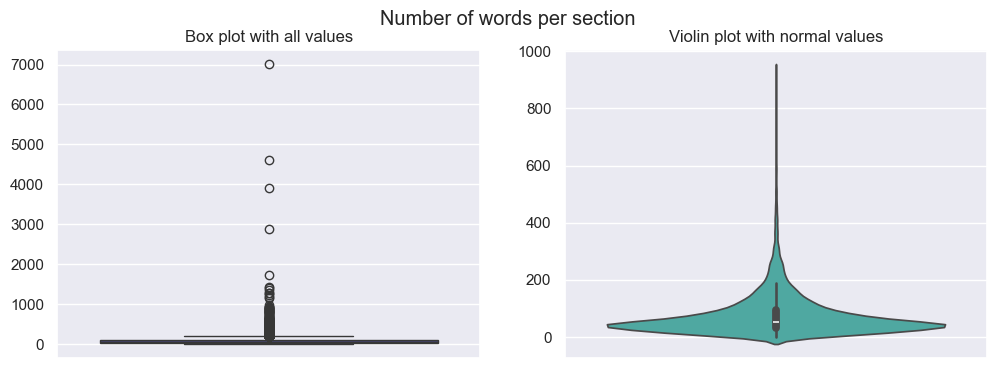

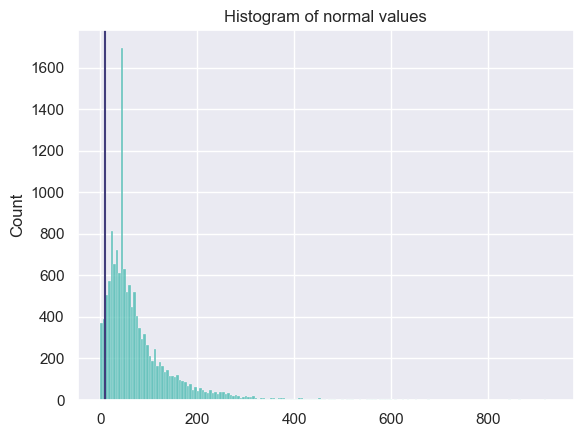

In [120]:
_, _, high_percentile_section_words = compute_statistics(np.array(words_per_section), high_percentile=99.9)
outlier_sections, number_of_empty_sections, normal_sections = separate_outliers(
    words_per_section, high_percentile_section_words, 0
)
minimum_words_per_section = np.percentile(words_per_section, 5)
too_small_sections = [val for val in words_per_section if val <= minimum_words_per_section]

print(f"There are {len(outlier_sections)} sections longer than {high_percentile_section_words - 1} words.")
print(f"There are {len(too_small_sections)} sections shorter than {int(minimum_words_per_section + 1)} words.")
print(f"There are {len(number_of_empty_sections)} empty sections.")

plot(words_per_section, normal_sections, "Number of words per section")
sns.histplot(np.array(normal_sections), color=sns.color_palette("mako")[4])
plt.axvline(minimum_words_per_section, color=sns.color_palette("mako")[1])
plt.title("Histogram of normal values")
plt.show()

##### 3.6. Average word length per header

Even though some headers have an average word length less than 2, they can have meaningful and long associated sections. Thus, we cannot remove outliers based on this criterion.

Min: 0.0
Max: 58.0
Mean: 7.224          
0.1 percentile: 1.0
99.9 percentile: 25.0



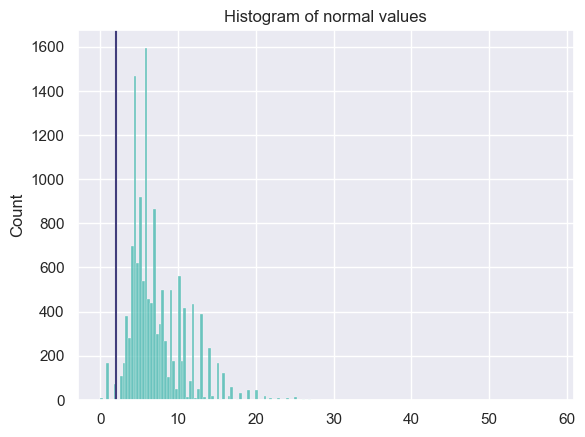

In [121]:
_, _, _ = compute_statistics(np.array(avg_word_len_header))
sns.histplot(np.array(avg_word_len_header), color=sns.color_palette("mako")[4])
plt.axvline(2, color=sns.color_palette("mako")[1])
plt.title("Histogram of normal values")
plt.show()

##### 3.7. Average word length per section

Min: 0.0
Max: 36.0
Mean: 5.2329          
0.1 percentile: 1.0
99.9 percentile: 17.0251



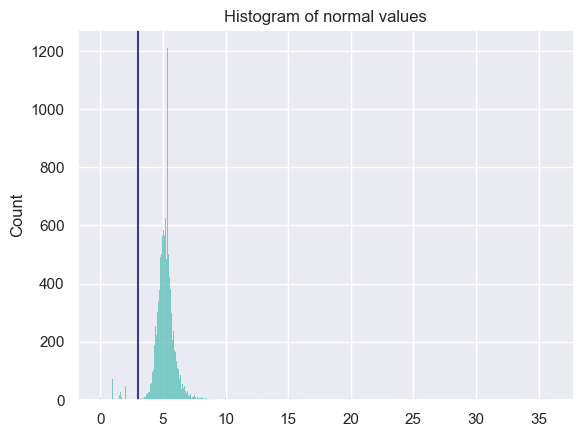

In [122]:
_, _, _ = compute_statistics(np.array(avg_word_len_section))
sns.histplot(np.array(avg_word_len_section), color=sns.color_palette("mako")[4])
plt.axvline(3, color=sns.color_palette("mako")[1])
plt.title("Histogram of normal values")
plt.show()

### 4. Find outlier header-section pairs

In [123]:
def contains_patterns(text):
    """
    This auxiliary function finds if the text contains patterns
    of interest or not.
    """

    found_patterns_no = 0
    patterns = [
        r"[0-9]{3}[ ]{1}[0-9]{3}[ ]{1}[0-9]{2}[ ]{1}[0-9]{2}",
        r"[0-9]{3}[-]{1}[0-9]{7}",
    ]

    for pattern in patterns:
        found_patterns = re.finditer(pattern, text)
        found_patterns_no += len(list(found_patterns))
    return found_patterns_no > 0


In [124]:
outlier_headers_sections = []
normal_headers_sections = []
normal_parsed_pdfs = dict()

# iterate over PDFs and find outliers
for file_name, data in dict(pdf_data).items():
    normal_sections_no = 0
    sections_number = len(data)

    if sections_number < 2:
        continue
    else:
        normal_parsed_pdfs[file_name.replace(".pdf", "")] = dict()
    for header, section in data.items():
        (
            paragraphs_per_section_,
            paragraphs_per_header_,
            words_per_section_,
            words_per_header_,
            avg_word_len_section_,
            avg_word_len_header_,
        ) = get_properties(header, section)

        # check based on domain knowledge rules if the current section is an outlier
        if (
            (
                paragraphs_per_header_ > 1
                or words_per_header_ == 0
                or words_per_section_ >= high_percentile_section_words
                or words_per_header_ >= high_percentile_header_words
            )
            or (
                words_per_section_ <= minimum_words_per_section
                and paragraphs_per_section_ == 1
                and not contains_patterns(section)
            )
            or (avg_word_len_section_ <= 2)
        ):
            # store outlier sections together with their header
            outlier_headers_sections.append([f"{file_name} --- {header}", section])
        else:
            # store normal sections together with their header
            normal_sections_no += 1
            normal_headers_sections.append([f"{file_name} --- {header}", section])
            normal_parsed_pdfs[file_name.replace(".pdf", "")][header] = section

    # remove dictionary entries without any normal sections
    if normal_sections_no == 0:
        del normal_parsed_pdfs[file_name.replace(".pdf", "")]

outliers_percentage = round(len(outlier_headers_sections) / number_of_sections * 100, 2)
print(
    f"The percentage of found outlier header-section pairs is {outliers_percentage}%."
)


The percentage of found outlier header-section pairs is 5.16%.


### 5. Check the outlier detection results and store the filtered dataset

In [125]:
def get_sample(data, store_data=False, name="", sample_size=5):
    """
    This function randomly samples a number of header-section pairs,
    print them and store in a TSV format for further use.
    """

    # randomly sample a number of sample_size indices
    outlier_indices = random.sample(range(0, len(data)), sample_size)
    sample_data = []

    for outlier_index in outlier_indices:
        header, section = data[outlier_index]
        # store the filename and the section text in a list
        sample_data.append([header.split(" --- ")[0], section])
        # print header together with its section
        print(f"\n{32 * '-'}\n***{header.split(' --- ')[1]}***\n{section}")   

    if store_data:
        with open(f"./data/{name}.tsv", "w") as file:
            # store the section id, which starts from 0, the file name and the section text
            file.write(f"id\ttext\ttitles\n")
            for index, info in enumerate(sample_data):
                # before writing the data, remove \n and \t characters to avoid ambiguities
                file.write(f"{index}\t{info[0].replace('\n', ' ').replace('\t', ' ')}\t"\
                           f"{info[1].replace('\n', ' ').replace('\t', ' ')}\n")

In [126]:
get_sample(outlier_headers_sections, store_data=True, name="outlier_sections", sample_size=100)


--------------------------------
***Stap 6.***
Adem langzaam en volledig uit, niet in de Turbuhaler®.

--------------------------------
***Stap 5: Draai het driewegkraantje weer dicht Stap 7: Zet de sondevoedingspomp weer aan Stap 6: Draai het dopje weer op het***
bijspuitpunt

--------------------------------
***Consultteam ondersteunende en***
palliatieve zorg

--------------------------------
***C***
G B

--------------------------------
***Duur van het onderzoek***
Het onderzoek duurt ongeveer vijftien minuten.

--------------------------------
***Middagmaaltijd: ***
Naar keuze uit onderstaande voedingslijst

--------------------------------
***Plasdagboek nachtelijke incontinentie***
Naam: Datum:

--------------------------------
***De afspraak***
De afspraak is gepland op: Dag: ………………………………………………………………… Datum: ……………………………………………………………. Tijd:………………………………………………………………….

--------------------------------
***3.1 Wat zijn uitzaaiingen van het melanoom?***
5

---------------------------

In [127]:
get_sample(normal_headers_sections, store_data=True, name="normal_sections", sample_size=100)


--------------------------------
***Voldoende drinken***
Het is belangrijk om voldoende te drinken. Vocht geeft snel een vol gevoel waardoor voldoende inname aan drinkvocht in het gedrang kan komen. Streef naar tenminste 1½ - 2 liter (12-16 kopjes) drinkvocht goed verspreid over de dag. Aan de hand van de urine kunt u controleren of u voldoende drinkt. De urine moet licht geel van kleur zijn en minimaal 1 liter per 24 uur bedragen.

--------------------------------
***Symptomen***
Divertikels geven meestal geen klachten. Klachten die wel kunnen optreden zijn vage buikpijn, buikkrampen, obstipatie en/of diarree. De klachten ontstaan vaak pas wanneer de divertikels gaan ontsteken. Hoe het proces van diverticulitis zal verlopen, hangt af van waar de divertikels zich in uw darm bevinden, de ernst van het ontstekingsproces en de aanwezigheid van complicaties. Pas als ze ontstoken raken (=diverticulitis), kunnen de volgende klachten ontstaan: 
- vaak pijn links in de buik; 
- opgezette buik

In [128]:
# save data locally in JSON format
with open(OUTPUT_FILE_PATH, "w") as file:
    file.write(json.dumps(normal_parsed_pdfs, indent=4))
